In [1]:
!pip install opencv-python
!pip install imutils


In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours

In [3]:
'''import requests, zipfile, io

# Step 1: Download the zip file
url = "https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip"
response = requests.get(url)

# Step 2: Unzip the file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()  # Extracts all contents to the current directory'''


'import requests, zipfile, io\n\n# Step 1: Download the zip file\nurl = "https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/data.zip"\nresponse = requests.get(url)\n\n# Step 2: Unzip the file\nwith zipfile.ZipFile(io.BytesIO(response.content)) as z:\n    z.extractall()  # Extracts all contents to the current directory'

In [4]:
x = []
y = []
datadir = 'data/dataset'
for folder in os.listdir(datadir):
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

7600
7600
labels : ['add', 'div', '4', '0', '6', 'mul', '9', 'sub', '7', '3', '2', '1', '5', '8']


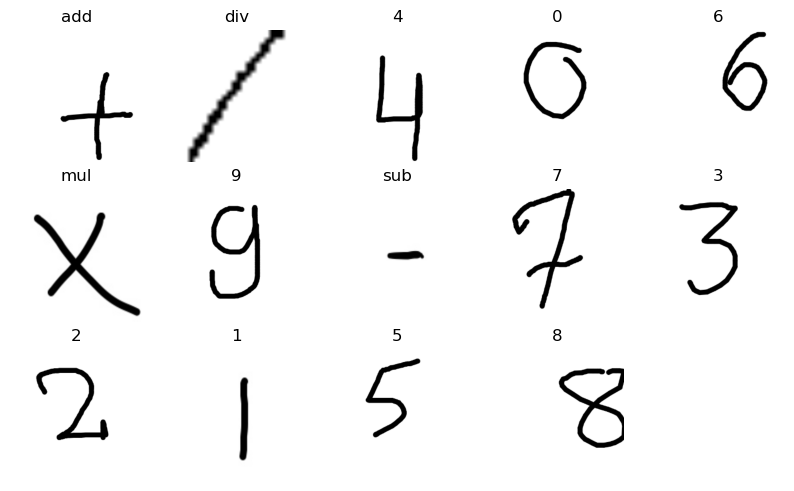

In [5]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

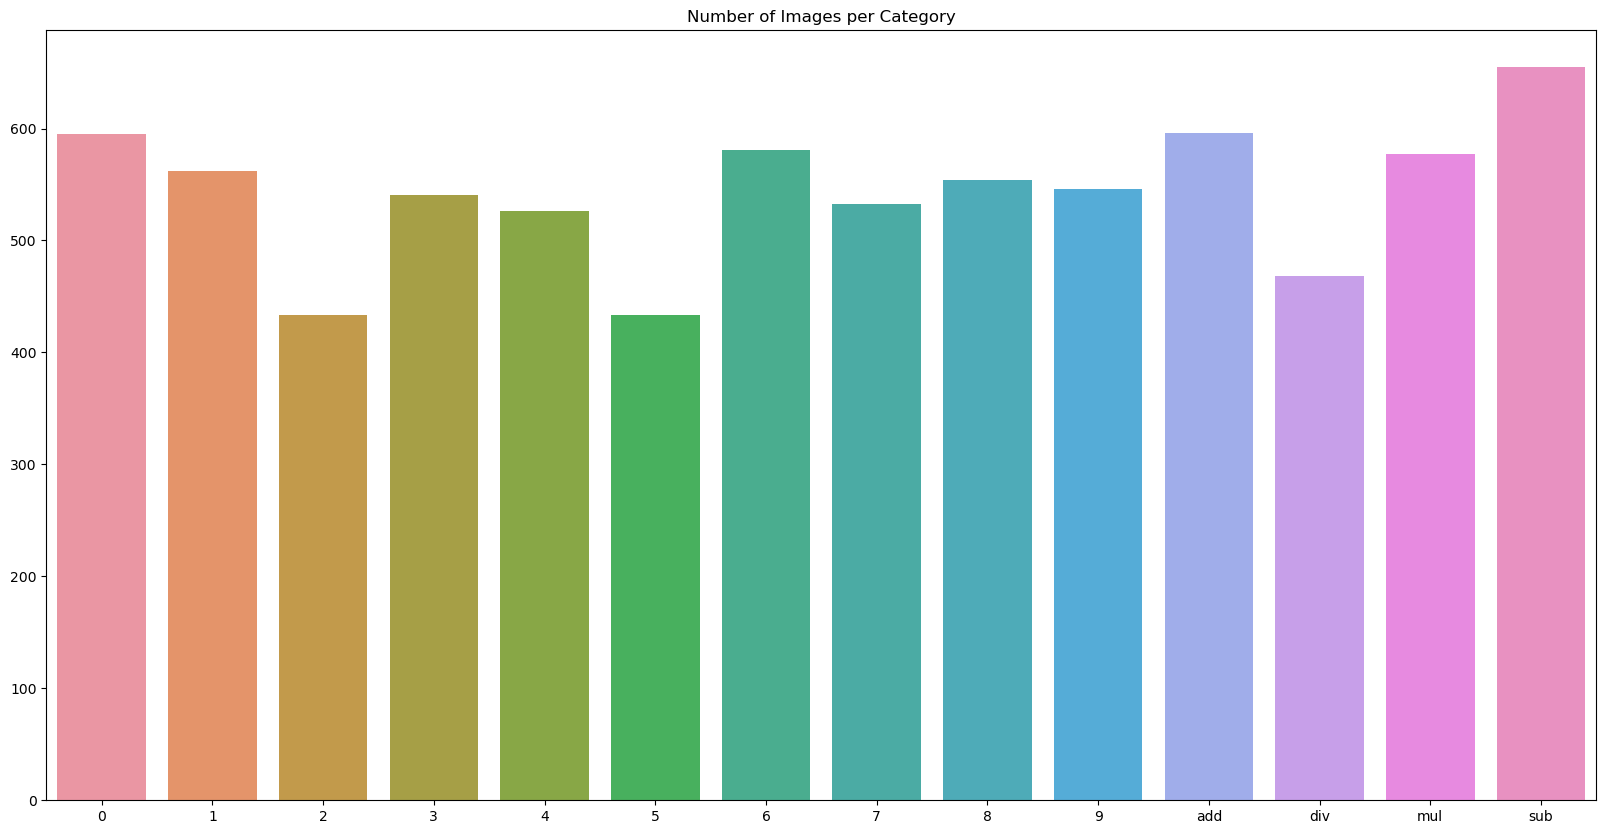

In [6]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique,y=count).set_title('Number of Images per Category')
plt.show()

In [7]:
X = []
for i in range(len(x)):
#     print(i)
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

7600


In [8]:
label_encoder = LabelEncoder() #[0,1,2,......]
y = label_encoder.fit_transform(y)
print(len(y))

7600


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

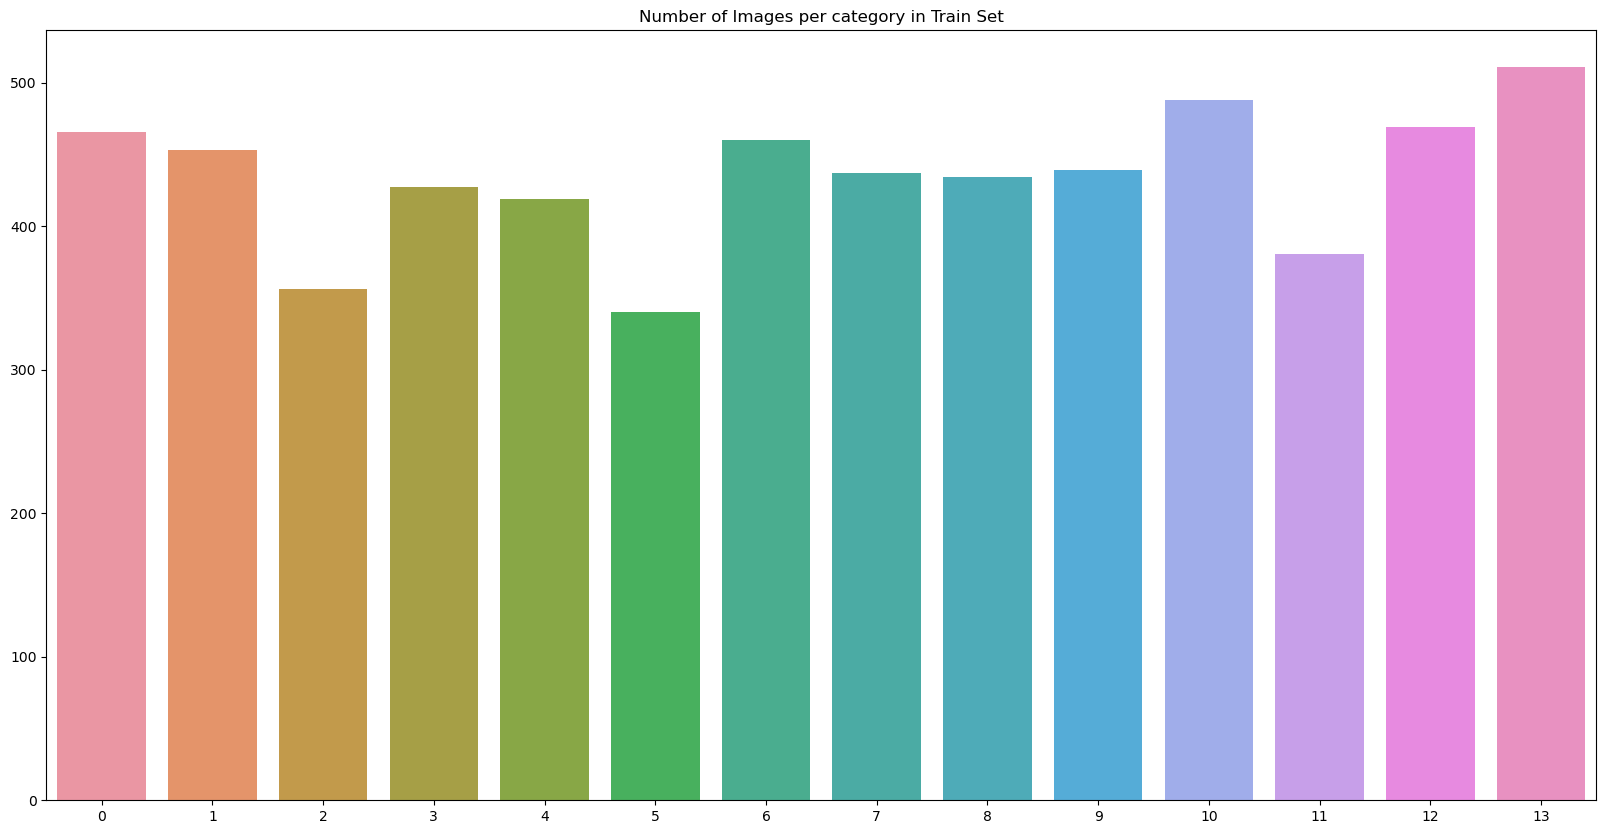

In [10]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique_train,y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

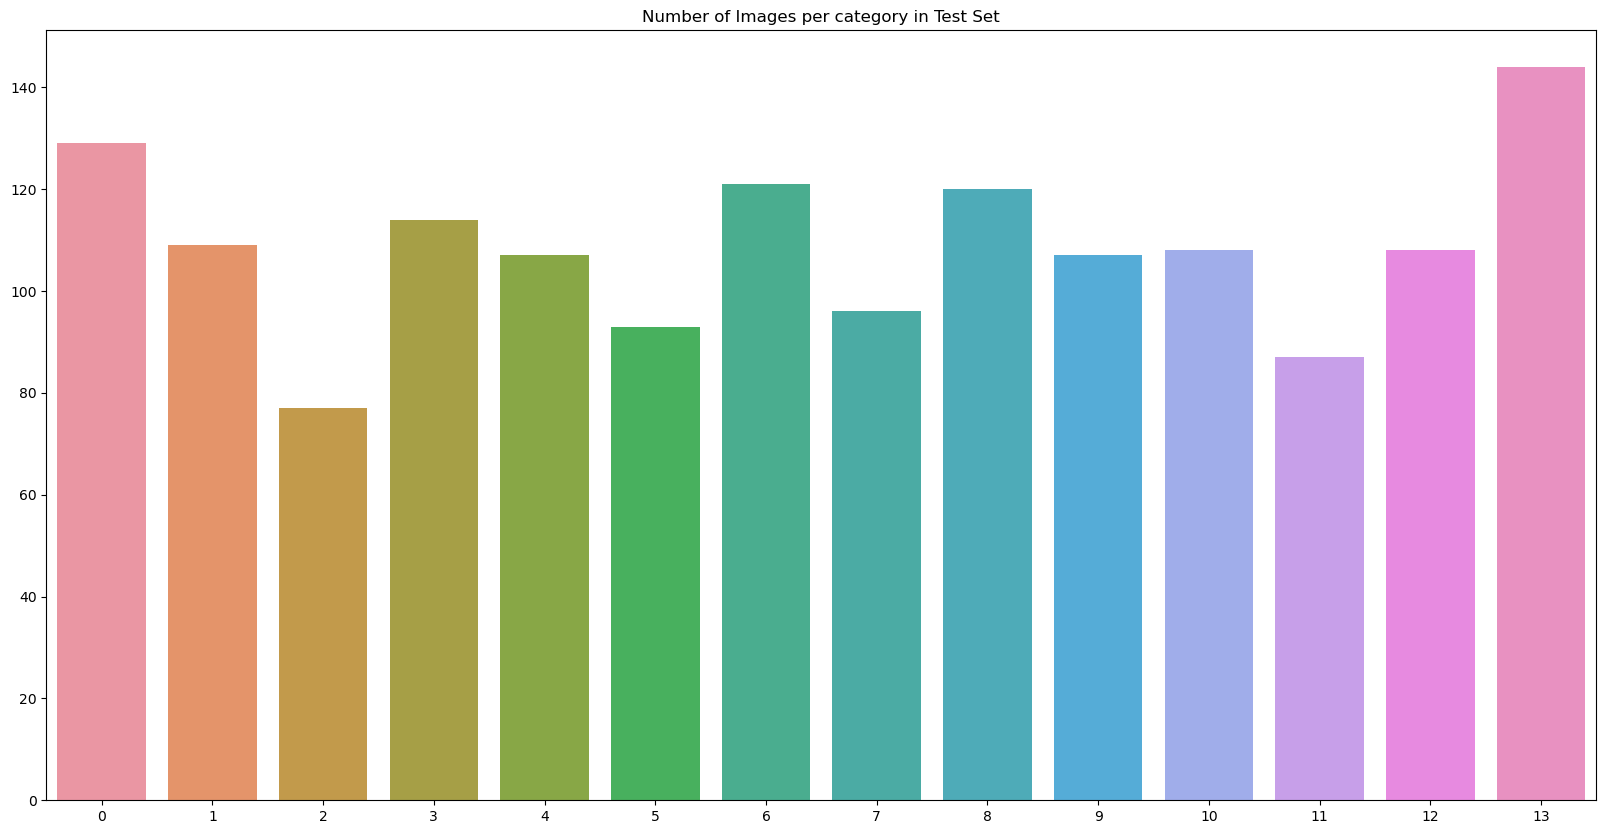

In [11]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sn.barplot(x=unique_test,y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train) #if label is 3 then [ 0 0 1 0 0 .....0]
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6080, 32, 32, 1)
(1520, 32, 32, 1)
(6080, 14)
(1520, 14)


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def math_symbol_and_digits_recognition(input_shape=(32, 32, 1), num_classes=14):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    
    # First Convolutional Layer
    model.add(Conv2D(32, (5, 5), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer)) #Conv2D layers detect patterns by applying filters across the image.
    model.add(Activation('relu', name='act1')) #activation introduces non-linearity, making the network capable of learning complex patterns.
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same')) #MaxPooling downsamples the feature maps, reducing spatial dimensions and model complexity.
    
    # Second Convolutional Layer
    model.add(Conv2D(64, (5, 5), strides=(1, 1), padding='same',
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation('relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2), padding='same'))
    
    # Flatten layer
    model.add(Flatten())
    
    # Fully Connected Layer with 1024 neurons
    model.add(Dense(1024, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dropout(0.5))  # Adding dropout for regularization
    
    # Output Layer for Classification
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    
    # Compile the model
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model    

In [14]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act1 (Activation)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ act2 (Activation)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 1024)                │       4,195,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 14)                  │          14,350 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,261,774 (16.26 MB)

 Trainable params: 4,261,774 (16.26 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('maths_symbol_and_digits_recognition.keras', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

In [16]:
aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))
# hist2 = model2.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/100


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.2376 - loss: 60.7623 - val_accuracy: 0.4428 - val_loss: 26.2181
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.4350 - loss: 10.4067 - val_accuracy: 0.4730 - val_loss: 12.7314
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.5008 - loss: 5.1973 - val_accuracy: 0.5461 - val_loss: 7.9650
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.5390 - loss: 3.4903 - val_accuracy: 0.5197 - val_loss: 5.6945
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5691 - loss: 2.6637 - val_accuracy: 0.5296 - val_loss: 4.3883
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5903 - loss: 2.1864 - val_accuracy: 0.5658 - val_loss: 3.5316
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6350 - loss: 1.8470 - val_accuracy: 0.5401 - val_loss: 3.1279
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.6411 - loss: 1.6838 - val_accuracy: 0.

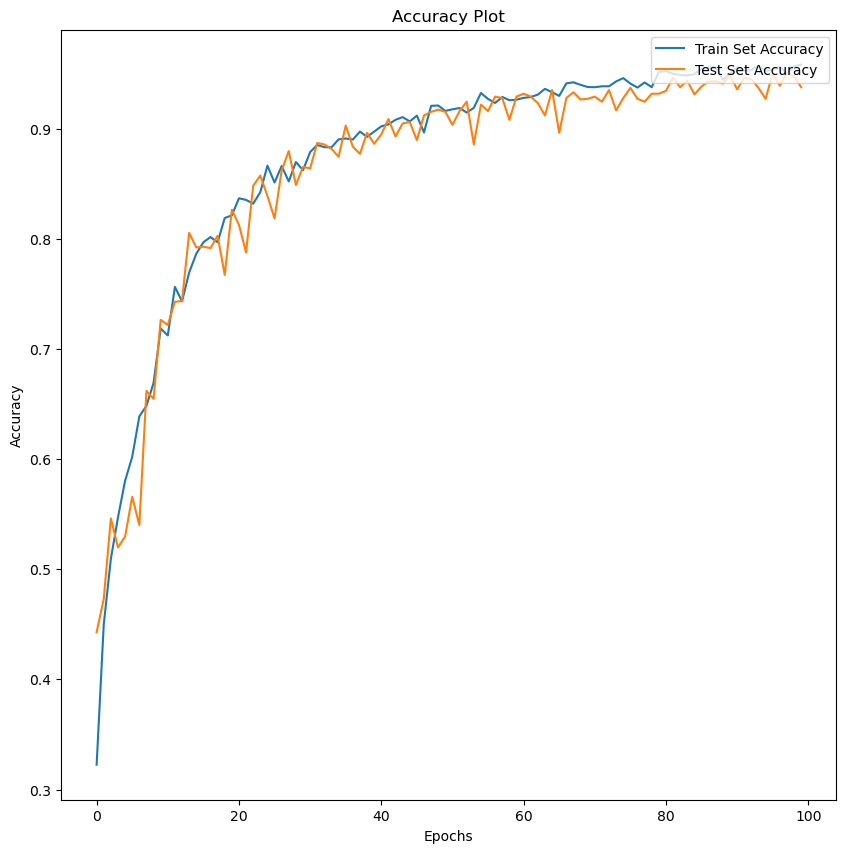

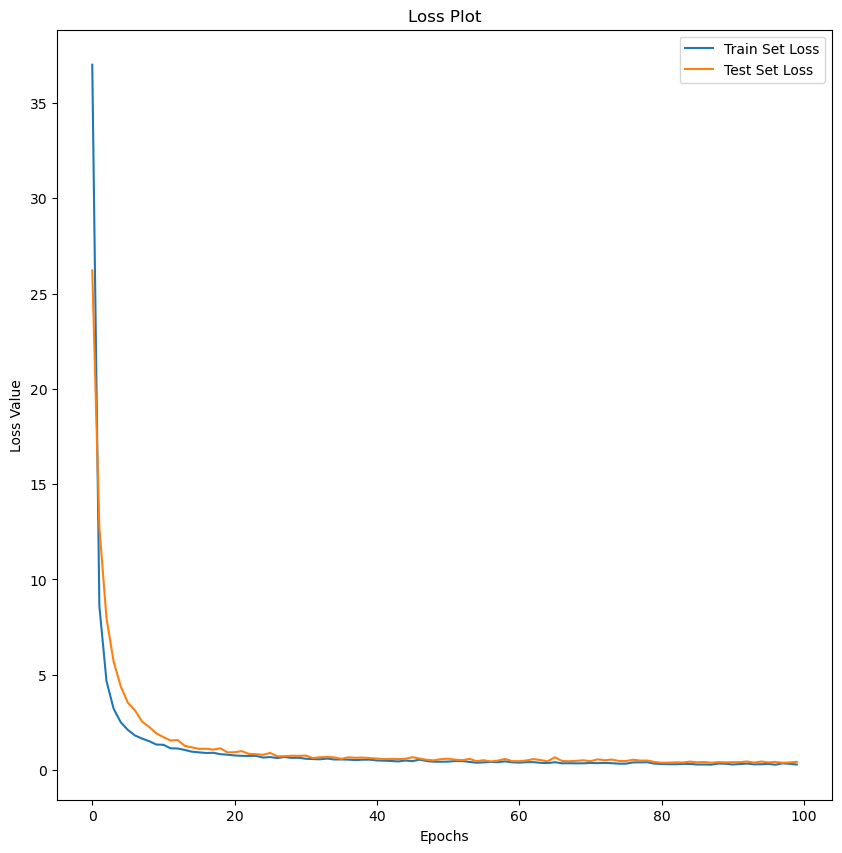

In [17]:
'''  Loss and Accuracy Plot '''
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

In [18]:
''' Classification report'''
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_hat, ypred)) # macro avg- mean of a metric

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       129
           1       1.00      0.89      0.94       109
           2       0.99      0.91      0.95        77
           3       0.92      0.83      0.88       114
           4       0.90      0.97      0.93       107
           5       0.95      0.90      0.93        93
           6       0.96      0.93      0.94       121
           7       0.97      0.92      0.94        96
           8       0.83      0.92      0.87       120
           9       0.87      0.97      0.92       107
          10       0.97      0.94      0.96       108
          11       1.00      1.00      1.00        87
          12       1.00      0.94      0.97       108
          13       1.00      0.99      0.99       144

    accuracy                           0.94      1520
   macro avg       0.94      0.94      0.94      1520
weighted avg       0.94      0.94      0.

<Axes: >

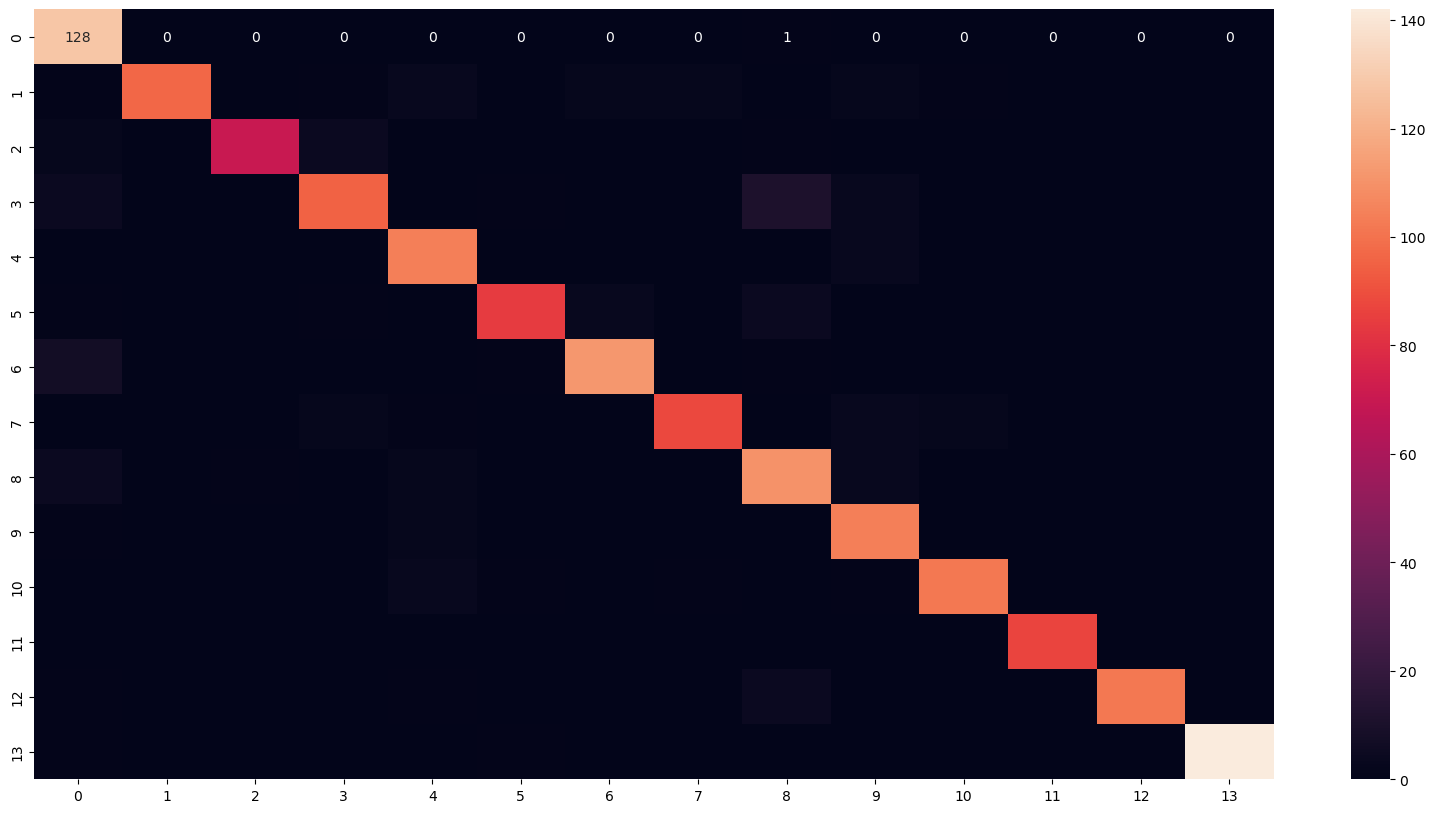

In [19]:
matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sn.heatmap(df_cm, annot=True, fmt='d')

In [20]:
''' saving the model ''' 
model.save('maths_symbol_and_digit_recognition.keras')

In [21]:
'''testing the model '''
def test_pipeline(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 5<=w and 5<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
            label = labels[pred[0]]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


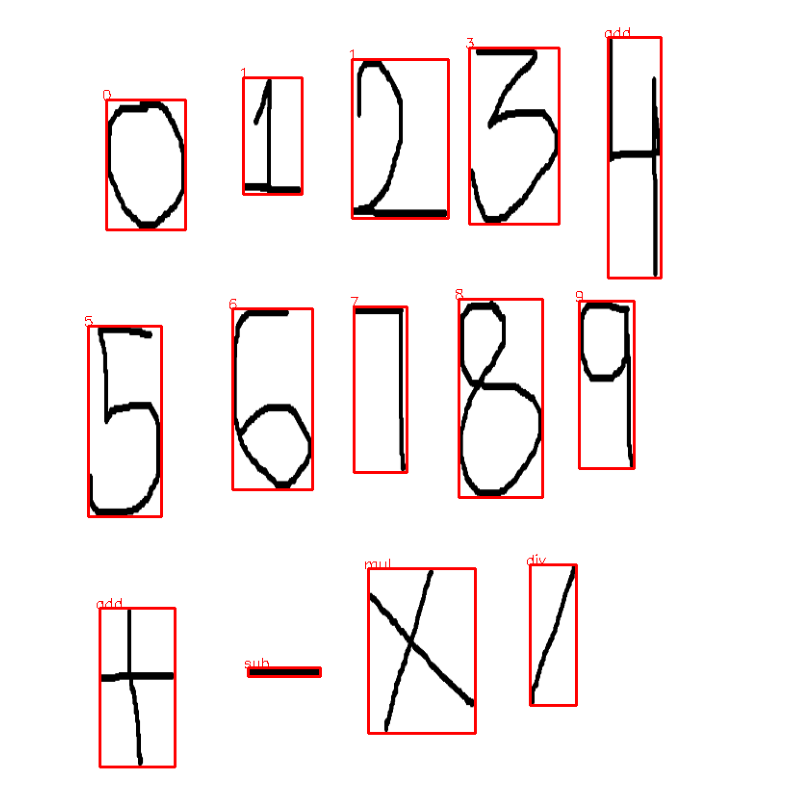

In [22]:
test_pipeline('data/testing_calSoftware.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


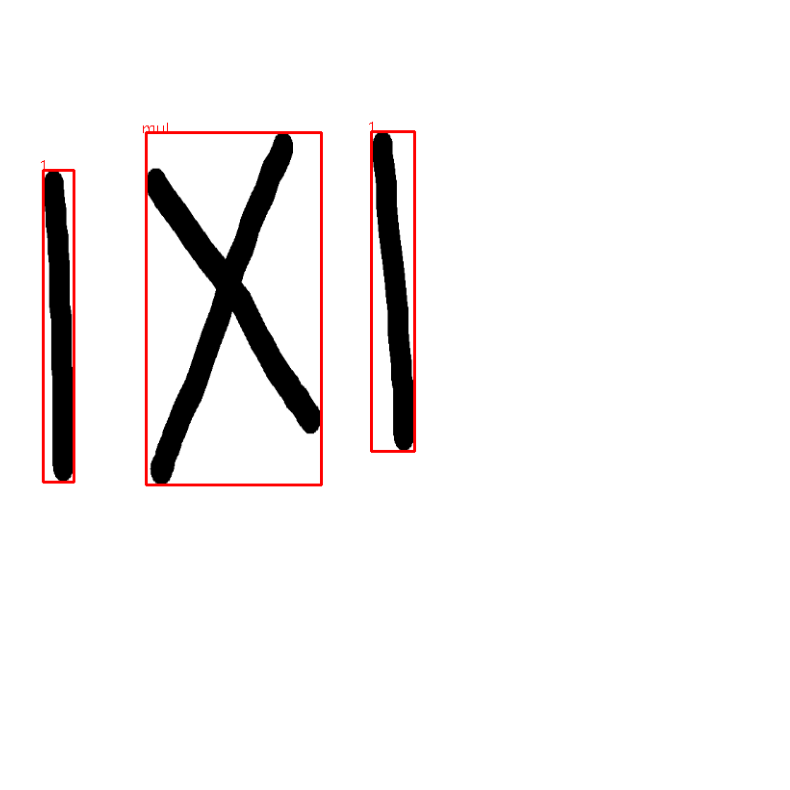

Value of the expression 1*1 : 1


In [23]:
    image_path =r"C:\Users\hp\Assignments ML\data\testing_3_ms.png"
    chars = []
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 800))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurred = cv2.GaussianBlur(img_gray, (3, 3), 0)
    edged = cv2.Canny(img_gray, 30, 150)
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sort_contours(contours, method="left-to-right")[0]
    labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'div', 'mul', 'sub']

    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if 5<=w and 5<=h:
            roi = img_gray[y:y+h, x:x+w]
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (th, tw) = thresh.shape
            if tw > th:
                thresh = imutils.resize(thresh, width=32)
            if th > tw:
                thresh = imutils.resize(thresh, height=32)
            (th, tw) = thresh.shape
            dx = int(max(0, 32 - tw)/2.0)
            dy = int(max(0, 32 - th) / 2.0)
            padded = cv2.copyMakeBorder(thresh, top=dy, bottom=dy, left=dx, right=dx, borderType=cv2.BORDER_CONSTANT,
                                       value=(0, 0, 0))
            padded = cv2.resize(padded, (32, 32))
            padded = np.array(padded)
            padded = padded/255.
            padded = np.expand_dims(padded, axis=0)
            padded = np.expand_dims(padded, axis=-1)
            pred = model.predict(padded)
            pred = np.argmax(pred, axis=1)
    #         print(pred)
            label = labels[pred[0]]
            chars.append(label)
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(img, label, (x-5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

    figure = plt.figure(figsize=(10, 10))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    e = ''
    for i in chars:
        if i=='add':
            e += '+'
        elif i=='sub':
            e += '-'
        elif i=='mul':
            e += '*'
        elif i=='div':
            e += '/'
        else:
            e += i
    v = eval(e)
    print('Value of the expression {} : {}'.format(e, v)) 

In [24]:
import numpy as np

# Directory to save weights and biases
save_dir = "weights_biases"

# Create the directory if it doesn't exist
import os
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save weights and biases for each layer
for layer in model.layers:
    if len(layer.get_weights()) > 0:
        weights, biases = layer.get_weights()
        
        # Convert weights to hex and save to file
        weights_hex = [format(int(w * (2**8)), '02x') for w in weights.flatten()]
        with open(f"{save_dir}/{layer.name}_weights_hex.txt", "w") as f:
            f.write("\n".join(weights_hex))
        
        # Convert biases to hex and save to file
        biases_hex = [format(int(b * (2**8)), '02x') for b in biases]
        with open(f"{save_dir}/{layer.name}_biases_hex.txt", "w") as f:
            f.write("\n".join(biases_hex))

print("Weights and biases have been saved in hex format successfully!")



Weights and biases have been saved in hex format successfully!


In [25]:
import numpy as np
import os

# Directory to save weights and biases
save_dir = "weights_biases"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Open files to save all weights and biases in hex format
with open(f"{save_dir}/all_weights_hex.txt", "w") as weights_file, \
     open(f"{save_dir}/all_biases_hex.txt", "w") as biases_file:
    
    # Loop over each layer in the model
    for layer in model.layers:
        # Check if the layer has weights
        if len(layer.get_weights()) > 0:
            weights, biases = layer.get_weights()
            
            # Convert weights to hex and write to weights file
            weights_hex = [format(int(w * (2**8)), '02x') for w in weights.flatten()]
            weights_file.write("\n".join(weights_hex) + "\n")
            
            # Convert biases to hex and write to biases file
            biases_hex = [format(int(b * (2**8)), '02x') for b in biases]
            biases_file.write("\n".join(biases_hex) + "\n")

print("All layer weights and biases have been saved in separate files successfully!")


All layer weights and biases have been saved in separate files successfully!
